In [2]:
# Code for plots of sequence length vs r2 for different downsampled data
# this will be for the pca-cnn models

# Import Libraries
import tensorflow as tf
import numpy as np
import random
import keras_tuner as kt
from keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd 
import json
import os 
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 18,    # Default font size
                     'axes.titlesize': 20,   # Title font size
                     'axes.labelsize': 20,   # Axes label font size
                     'xtick.labelsize': 18,  # X-axis tick label font size
                     'ytick.labelsize': 18,
                     'legend.fontsize': 18}) # Y-axis tick label font size
# Define Test Function
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
def train_model(pc_num, seq_len,ds_factor, file_path):
	x_test=np.load('./pca-test.npy')
	df_test=pd.read_csv('./Test_full_set.csv')
	y_test=np.array(df_test['Heat Flux'].tolist())
	x_test=x_test[:,:pc_num]
	
	
	# Added for downsampling
	def downsample(arr, factor):
		dsarray=arr[::factor]
		return dsarray
	
	x_test=downsample(x_test, ds_factor)
	y_test=downsample(y_test,ds_factor)
	
	
	def split_data(signal,sl,st):
    		length=len(signal)
    		amt_samples=int((length-sl)/st)
    		data=np.empty((amt_samples,sl))
    		for i in range(amt_samples):
        		data[i]=signal[(i*st):(i*st)+sl]
        
    		return data

	index=[i for i in range(len(x_test))]
	index=split_data(index, seq_len, 1).astype(int)
	x_test=x_test[index]
	y_test=split_data(y_test,seq_len,1)[:,-1]
	print(x_test.shape, y_test.shape)
	condition=y_test>15
	x_test=x_test[condition]
	y_test=y_test[condition]

	
	
	x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1],x_test.shape[2],1))

	
	inputs=tf.keras.Input(shape=(x_test.shape[1],x_test.shape[2],1))
	hp_layer1_filter=72
	hp_layer1_kernel=3
	hp_layer1_stride=3
	x=tf.keras.layers.Conv2D(hp_layer1_filter, hp_layer1_kernel,strides=hp_layer1_stride, activation='relu')(inputs)
	#x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
	x=tf.keras.layers.Dropout(0.2)(x)
	hp_layer2_filter=72
	hp_layer2_kernel=5
	hp_layer2_stride=1
	x = tf.keras.layers.Conv2D(filters=hp_layer2_filter, kernel_size=hp_layer2_kernel,strides= hp_layer2_stride,padding='same', activation='relu')(x)
	hp_layer3_filter=92
	hp_layer3_kernel=5
	hp_layer3_stride=3
	x = tf.keras.layers.Conv2D(filters=hp_layer3_filter, kernel_size=hp_layer3_kernel, strides=hp_layer3_stride, padding='same',activation='relu')(x)
	x = tf.keras.layers.MaxPooling2D(pool_size=2,padding='same')(x)
	hp_layer4_filter=62
	hp_layer4_kernel=3
	hp_layer4_stride=1
	x = tf.keras.layers.Conv2D(filters=hp_layer4_filter, kernel_size=hp_layer4_kernel, strides=hp_layer4_stride,padding='same', activation='relu')(x)
	x=tf.keras.layers.Dropout(0.2)(x)
	#x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
	x = tf.keras.layers.Flatten()(x)
	hp_layer5_neurons=181
	x = tf.keras.layers.Dense(units=hp_layer5_neurons, activation='relu')(x)
	hp_layer6_neurons=931
	x = tf.keras.layers.Dense(units=hp_layer6_neurons, activation='relu')(x)
	outputs = tf.keras.layers.Dense(units=1)(x)

	model=tf.keras.models.Model(inputs=inputs, outputs=outputs)
	
	model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='MSE')
			
	model.load_weights(file_path)

	predict=model.predict(x_test)
	
	return predict, y_test


2024-07-19 12:11:26.166734: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
plt.rcParams.update({'font.size': 18,    # Default font size
                     'axes.titlesize': 18,   # Title font size
                     'axes.labelsize': 18,   # Axes label font size
                     'xtick.labelsize': 16,  # X-axis tick label font size
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16}) # Y-axis tick label font size

(12901, 10, 40) (12901,)


2024-07-19 11:16:33.371149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-19 11:16:33.388108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-19 11:16:33.388214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-19 11:16:33.388479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

139/273 [==============>...............] - ETA: 0s

2024-07-19 11:16:34.228992: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


273/273 [==============================] - 1s 1ms/step
(12881, 30, 40) (12881,)
273/273 [==============================] - 0s 2ms/step
(12871, 40, 40) (12871,)
273/273 [==============================] - 0s 829us/step
(12851, 60, 40) (12851,)
273/273 [==============================] - 0s 820us/step
(12811, 100, 40) (12811,)
273/273 [==============================] - 0s 883us/step
(12711, 200, 40) (12711,)
149/273 [===============>..............] - ETA: 0s

2024-07-19 11:16:37.188486: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 967.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-19 11:16:37.188506: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 967.12MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


273/273 [==============================] - 0s 1ms/step
(12901, 10, 40) (12901,)


2024-07-19 11:16:37.482460: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 738.60MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-19 11:16:37.482484: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 738.60MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


273/273 [==============================] - 0s 650us/step
(12881, 30, 40) (12881,)
273/273 [==============================] - 0s 664us/step
(12871, 40, 40) (12871,)
273/273 [==============================] - 0s 767us/step
(12851, 60, 40) (12851,)
273/273 [==============================] - 0s 730us/step
(12811, 100, 40) (12811,)
273/273 [==============================] - 0s 872us/step
(12711, 200, 40) (12711,)


2024-07-19 11:16:50.061629: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 265.84MiB (rounded to 278752000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-07-19 11:16:50.061646: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2024-07-19 11:16:50.061650: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 70, Chunks in use: 70. 17.5KiB allocated for chunks. 17.5KiB in use in bin. 2.2KiB client-requested in use in bin.
2024-07-19 11:16:50.061653: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 32, Chunks in use: 32. 18.8KiB allocated for chunks. 18.8KiB in use in bin. 13.0KiB client-requested in use in bin.
2024-07-19 11:16:50.06165

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

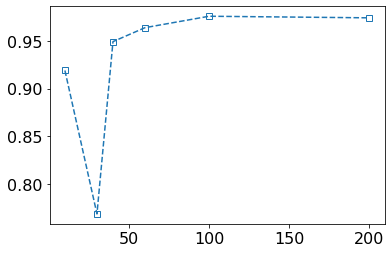

In [3]:
# 
vals=[[5,10],[5,30],[5,40],[5,60],[5,100],[5,200],[5,400],
[10,10],[10,30],[10,40],[10,60],[10,100],[10,200],[10,400],
[40,10],[40,30],[40,40],[40,60],[40,100],[40,200]]

ds_vals=[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ds_fps=[50,38,30,25,22,19,17,15,14,13,12,11,10,9,9,9,8,8]
ds_vals=[3,4,5,6,7,8,9,10]
ds_fps=[50,38,30,25,22,19,17,15,14,13,12,11,10,9,9,9,8,8]
pcs=[5,10,40]
pcs=[40]
sls=[10,30,40,60,100,200]
ds_vals=[3,5,6,10]
fps=[150,75,50,30,25,15]
ds_fps=[50,30,25,15]
for i in range(len(pcs)):
	r2_vals=[]
	for k in range(len(sls)):
		file_path=f'./cnn-pc{pcs[i]}_sl{sls[k]}.hdf5'
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(r2_score(y_test,predict))
	plt.plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[0]} fps')
	r2_vals=[]
	for k in range(len(sls)):
		file_path=f"./ds_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(r2_score(y_test,predict))
	plt.plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[1]} fps')
	for j in range(len(ds_vals)):
		r2_vals=[]

		for k in range(len(sls)):
			file_path=f"./ds{ds_vals[j]}_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
			predict, y_test=train_model(pcs[i], sls[k],ds_vals[j], file_path)
			r2_vals.append(r2_score(y_test,predict))
		plt.plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[j+2]} fps')
	plt.legend()
	plt.xlabel('Sequence Length (# of Images)')
	plt.ylabel(r'$R^2$')
	plt.savefig('./Figures/ds_sl_r2.png')      
	plt.show()


(12901, 10, 40) (12901,)
273/273 [==============================] - 0s 644us/step
(12881, 30, 40) (12881,)
273/273 [==============================] - 0s 662us/step
(12871, 40, 40) (12871,)
273/273 [==============================] - 0s 750us/step
(12851, 60, 40) (12851,)
273/273 [==============================] - 0s 782us/step
(12811, 100, 40) (12811,)
273/273 [==============================] - 0s 827us/step
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 990us/step
(12901, 10, 40) (12901,)
273/273 [==============================] - 0s 1ms/step
(12881, 30, 40) (12881,)
273/273 [==============================] - 0s 1ms/step
(12871, 40, 40) (12871,)
273/273 [==============================] - 0s 665us/step
(12851, 60, 40) (12851,)
273/273 [==============================] - 0s 2ms/step
(12811, 100, 40) (12811,)
273/273 [==============================] - 0s 1ms/step
(12711, 200, 40) (12711,)
273/273 [==============================] - 1s 2ms/step
(4294, 10, 40) (4294,)

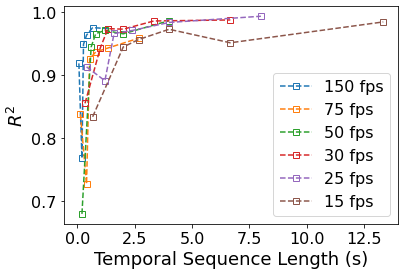

In [5]:
for i in range(len(pcs)):
	r2_vals=[]
	temp=[]
	for k in range(len(sls)):
		file_path=f'./cnn-pc{pcs[i]}_sl{sls[k]}.hdf5'
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(r2_score(y_test,predict))
		temp.append(sls[k]/150)
	plt.plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[0]} fps')
	
	r2_vals=[]
	temp=[]
	for k in range(len(sls)):
		file_path=f"./ds_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(r2_score(y_test,predict))
		temp.append(sls[k]/75)
	plt.plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[1]} fps')
	
	for j in range(len(ds_vals)):
		
		r2_vals=[]
		temp=[]
		for k in range(len(sls)):
			file_path=f"./ds{ds_vals[j]}_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
			predict, y_test=train_model(pcs[i], sls[k],ds_vals[j],file_path)
			r2_vals.append(r2_score(y_test,predict))
			temp.append(sls[k]/ds_fps[j])
		plt.plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[j+2]} fps')
	plt.xlabel('Temporal Sequence Length (s)')
	plt.ylabel(r'$R^2$')
	plt.legend()
	plt.savefig('./Figures/ds_tsl_r2.png')      
	plt.show()
	plt.close()



(12901, 10, 40) (12901,)
273/273 [==============================] - 0s 609us/step
(12881, 30, 40) (12881,)
273/273 [==============================] - 0s 688us/step
(12871, 40, 40) (12871,)
273/273 [==============================] - 0s 915us/step
(12851, 60, 40) (12851,)
273/273 [==============================] - 0s 831us/step
(12811, 100, 40) (12811,)
273/273 [==============================] - 0s 1ms/step
(12711, 200, 40) (12711,)
273/273 [==============================] - 1s 2ms/step
(12901, 10, 40) (12901,)
273/273 [==============================] - 0s 1ms/step
(12881, 30, 40) (12881,)
273/273 [==============================] - 1s 2ms/step
(12871, 40, 40) (12871,)
273/273 [==============================] - 0s 703us/step
(12851, 60, 40) (12851,)
273/273 [==============================] - 0s 772us/step
(12811, 100, 40) (12811,)
273/273 [==============================] - 0s 787us/step
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 1ms/step
(4294, 10, 40) (4294,)

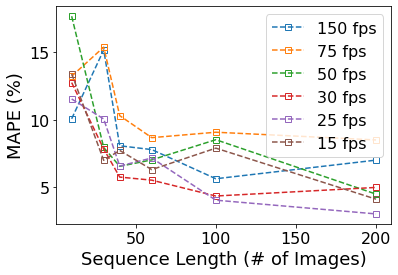

In [6]:
for i in range(len(pcs)):
	r2_vals=[]
	for k in range(len(sls)):
		file_path=f'./cnn-pc{pcs[i]}_sl{sls[k]}.hdf5'
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(mean_absolute_percentage_error(y_test,predict))

	r2_vals=np.array(r2_vals)*100
	plt.plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[0]} fps')
	r2_vals=[]
	for k in range(len(sls)):
		file_path=f"./ds_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(mean_absolute_percentage_error(y_test,predict))

	r2_vals=np.array(r2_vals)*100
	plt.plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[1]} fps')
	for j in range(len(ds_vals)):
		r2_vals=[]

		for k in range(len(sls)):
			file_path=f"./ds{ds_vals[j]}_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
			predict, y_test=train_model(pcs[i], sls[k],ds_vals[j], file_path)
			r2_vals.append(mean_absolute_percentage_error(y_test,predict))
		r2_vals=np.array(r2_vals)*100
		plt.plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[j+2]} fps')
	plt.legend()
	plt.xlabel('Sequence Length (# of Images)')
	plt.ylabel(r'MAPE (%)')
	plt.savefig('./Figures/ds_sl_mape.png')      
	plt.show()
	plt.close()

(12901, 10, 40) (12901,)
273/273 [==============================] - 0s 628us/step
(12881, 30, 40) (12881,)
273/273 [==============================] - 0s 700us/step
(12871, 40, 40) (12871,)
273/273 [==============================] - 0s 955us/step
(12851, 60, 40) (12851,)
273/273 [==============================] - 1s 2ms/step
(12811, 100, 40) (12811,)
273/273 [==============================] - 0s 2ms/step
(12711, 200, 40) (12711,)
273/273 [==============================] - 0s 1ms/step
(12901, 10, 40) (12901,)
273/273 [==============================] - 0s 853us/step
(12881, 30, 40) (12881,)
273/273 [==============================] - 1s 2ms/step
(12871, 40, 40) (12871,)
273/273 [==============================] - 0s 1ms/step
(12851, 60, 40) (12851,)
273/273 [==============================] - 0s 1ms/step
(12811, 100, 40) (12811,)
273/273 [==============================] - 0s 1ms/step
(12711, 200, 40) (12711,)
273/273 [==============================] - 1s 2ms/step
(4294, 10, 40) (4294,)
91/91

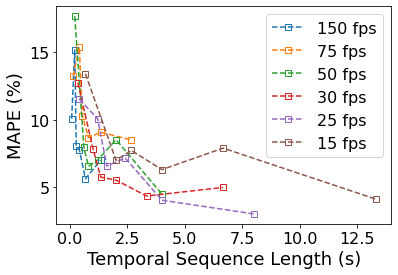

In [12]:
for i in range(len(pcs)):
	r2_vals=[]
	temp=[]
	for k in range(len(sls)):
		file_path=f'./cnn-pc{pcs[i]}_sl{sls[k]}.hdf5'
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(mean_absolute_percentage_error(y_test,predict))

		temp.append(sls[k]/150)
	r2_vals=np.array(r2_vals)*100
	plt.plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[0]} fps')
	
	r2_vals=[]
	temp=[]
	for k in range(len(sls)):
		file_path=f"./ds_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(mean_absolute_percentage_error(y_test,predict))

		temp.append(sls[k]/75)
	r2_vals=np.array(r2_vals)*100
	plt.plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[1]} fps')
	
	for j in range(len(ds_vals)):
		
		r2_vals=[]
		temp=[]
		for k in range(len(sls)):
			file_path=f"./ds{ds_vals[j]}_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
			predict, y_test=train_model(pcs[i], sls[k],ds_vals[j],file_path)
			r2_vals.append(mean_absolute_percentage_error(y_test,predict))
		
			temp.append(sls[k]/ds_fps[j])
		r2_vals=np.array(r2_vals)*100	
		plt.plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[j+2]} fps')
plt.xlabel('Temporal Sequence Length (s)')
plt.ylabel('MAPE (%)')
plt.legend()
plt.savefig('./Figures/ds_tsl_mape.png')      
plt.show()


(12901, 10, 40) (12901,)
273/273 [==============================] - 0s 1ms/step
(12881, 30, 40) (12881,)
273/273 [==============================] - 0s 2ms/step
(12871, 40, 40) (12871,)
273/273 [==============================] - 1s 2ms/step
(12851, 60, 40) (12851,)
273/273 [==============================] - 0s 1ms/step
(12811, 100, 40) (12811,)
273/273 [==============================] - 0s 889us/step
(12711, 200, 40) (12711,)
273/273 [==============================] - 1s 2ms/step
(12901, 10, 40) (12901,)
273/273 [==============================] - 0s 2ms/step
(12881, 30, 40) (12881,)
273/273 [==============================] - 0s 781us/step
(12871, 40, 40) (12871,)
273/273 [==============================] - 0s 1ms/step
(12851, 60, 40) (12851,)
273/273 [==============================] - 0s 1ms/step
(12811, 100, 40) (12811,)
273/273 [==============================] - 0s 1ms/step
(12711, 200, 40) (12711,)
273/273 [==============================] - 1s 3ms/step
(4294, 10, 40) (4294,)
91/91 [==

'\n    \nfor i in range(len(pcs)):\n    r2_vals=[]\n    for k in range(len(sls)):\n        file_path=f\'./cnn-pc{pcs[i]}_sl{sls[k]}.hdf5\'\n        predict, y_test=train_model(pcs[i], sls[k],1, file_path)\n        r2_vals.append(mean_absolute_percentage_error(y_test,predict))\n\n    r2_vals=np.array(r2_vals)*100\n    axs[1,0].plot(sls,r2_vals,linestyle=\'dashed\', marker=\'s\', markerfacecolor=\'none\' ,label=f\'{fps[0]} fps\')\n    r2_vals=[]\n    for k in range(len(sls)):\n    file_path=f"./ds_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"\n        predict, y_test=train_model(pcs[i], sls[k],1, file_path)\n        r2_vals.append(mean_absolute_percentage_error(y_test,predict))\n\n    r2_vals=np.array(r2_vals)*100\n    axs[1,0].plot(sls,r2_vals,linestyle=\'dashed\', marker=\'s\', markerfacecolor=\'none\' ,label=f\'{fps[1]} fps\')\n    for j in range(len(ds_vals)):\n        r2_vals=[]\n\n        for k in range(len(sls)):\n\t\t\tfile_path=f"./ds{ds_vals[j]}_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"\n\t\t\tpredict

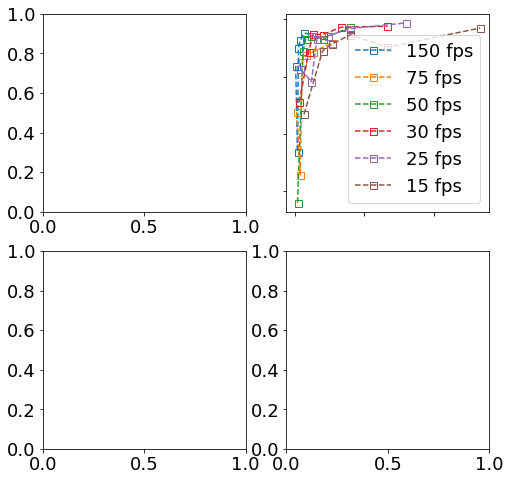

In [14]:
# 

import matplotlib.font_manager as font_manager

plt.rcParams.update({'font.size': 22,    # Default font size
                     'axes.titlesize': 2,   # Title font size
                     'axes.labelsize': 22,   # Axes label font size
                     'xtick.labelsize': 18,  # X-axis tick label font size
                     'ytick.labelsize': 18,
                    'lines.markersize':7,
                    'lines.markeredgewidth':1,
                    'lines.linewidth':1.5})

arial_font_path='/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
arial=font_manager.FontProperties(fname=arial_font_path)
fig, axs = plt.subplots(2, 2, figsize=(8,8))


vals=[[5,10],[5,30],[5,40],[5,60],[5,100],[5,200],[5,400],
[10,10],[10,30],[10,40],[10,60],[10,100],[10,200],[10,400],
[40,10],[40,30],[40,40],[40,60],[40,100],[40,200]]

ds_vals=[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ds_fps=[50,38,30,25,22,19,17,15,14,13,12,11,10,9,9,9,8,8]
ds_vals=[3,4,5,6,7,8,9,10]
ds_fps=[50,38,30,25,22,19,17,15,14,13,12,11,10,9,9,9,8,8]
pcs=[5,10,40]
pcs=[40]
sls=[10,30,40,60,100,200]
ds_vals=[3,5,6,10]
fps=[150,75,50,30,25,15]
ds_fps=[50,30,25,15]

'''
for i in range(len(pcs)):

	r2_vals=[]
	for k in range(len(sls)):
		file_path=f'./cnn-pc{pcs[i]}_sl{sls[k]}.hdf5'
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(r2_score(y_test,predict))
	axs[0,0].plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[0]} fps')
	r2_vals=[]
	for k in range(len(sls)):
		file_path=f"./ds_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(r2_score(y_test,predict))
	axs[0,0].plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[1]} fps')
	for j in range(len(ds_vals)):
		r2_vals=[]

		for k in range(len(sls)):
			file_path=f"./ds{ds_vals[j]}_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
			predict, y_test=train_model(pcs[i], sls[k],ds_vals[j], file_path)
			r2_vals.append(r2_score(y_test,predict))
		axs[0,0].plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[j+2]} fps')
	#plt.xlabel('Sequence Length (# of Images)')
axs[0,0].set_ylabel(r'$R^2$')
axs[0,0].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)


'''
    
for i in range(len(pcs)):
    r2_vals=[]
    temp=[]
    for k in range(len(sls)):
        file_path=f'./cnn-pc{pcs[i]}_sl{sls[k]}.hdf5'
        predict, y_test=train_model(pcs[i], sls[k],1, file_path)
        r2_vals.append(r2_score(y_test,predict))
        temp.append(sls[k]/150)
    axs[0,1].plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[0]} fps')

    r2_vals=[]
    temp=[]
    for k in range(len(sls)):
        file_path=f"./ds_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
        predict, y_test=train_model(pcs[i], sls[k],1, file_path)
        r2_vals.append(r2_score(y_test,predict))
        temp.append(sls[k]/75)
    axs[0,1].plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[1]} fps')
    
    for j in range(len(ds_vals)):
        
        r2_vals=[]
        temp=[]
        for k in range(len(sls)):
            file_path=f"./ds{ds_vals[j]}_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
            predict, y_test=train_model(pcs[i], sls[k],ds_vals[j],file_path)
            r2_vals.append(r2_score(y_test,predict))
            temp.append(sls[k]/ds_fps[j])
        if j==1:
            print(temp)
            print(r2_vals)
        axs[0,1].plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[j+2]} fps')

axs[0,1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
axs[0,1].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
axs[0,1].legend()


'''
    
for i in range(len(pcs)):
    r2_vals=[]
    for k in range(len(sls)):
        file_path=f'./cnn-pc{pcs[i]}_sl{sls[k]}.hdf5'
        predict, y_test=train_model(pcs[i], sls[k],1, file_path)
        r2_vals.append(mean_absolute_percentage_error(y_test,predict))

    r2_vals=np.array(r2_vals)*100
    axs[1,0].plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[0]} fps')
    r2_vals=[]
    for k in range(len(sls)):
    file_path=f"./ds_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
        predict, y_test=train_model(pcs[i], sls[k],1, file_path)
        r2_vals.append(mean_absolute_percentage_error(y_test,predict))

    r2_vals=np.array(r2_vals)*100
    axs[1,0].plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[1]} fps')
    for j in range(len(ds_vals)):
        r2_vals=[]

        for k in range(len(sls)):
			file_path=f"./ds{ds_vals[j]}_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
			predict, y_test=train_model(pcs[i], sls[k],ds_vals[j], file_path)
			r2_vals.append(mean_absolute_percentage_error(y_test,predict))
		r2_vals=np.array(r2_vals)*100
		axs[1,0].plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[j+2]} fps')
	axs[1,0].set_xlabel(f'Sequence Length\n(# of Images)')
	axs[1,0].set_ylabel(r'MAPE (%)')

    
    
for i in range(len(pcs)):
	r2_vals=[]
	temp=[]
	for k in range(len(sls)):
		file_path=f'./cnn-pc{pcs[i]}_sl{sls[k]}.hdf5'
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(mean_absolute_percentage_error(y_test,predict))

		temp.append(sls[k]/150)
	r2_vals=np.array(r2_vals)*100
	axs[1,1].plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[0]} fps')
	
	r2_vals=[]
	temp=[]
	for k in range(len(sls)):
		file_path=f"./ds_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(mean_absolute_percentage_error(y_test,predict))

		temp.append(sls[k]/75)
	r2_vals=np.array(r2_vals)*100
	axs[1,1].plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[1]} fps')
	
	for j in range(len(ds_vals)):
		
		r2_vals=[]
		temp=[]
		for k in range(len(sls)):
			file_path=f"./ds{ds_vals[j]}_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
			predict, y_test=train_model(pcs[i], sls[k],ds_vals[j],file_path)
			r2_vals.append(mean_absolute_percentage_error(y_test,predict))
		
			temp.append(sls[k]/ds_fps[j])
		r2_vals=np.array(r2_vals)*100	
		axs[1,1].plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[j+2]} fps')
axs[1,1].set_xlabel(f'Temporal Sequence\nLength (s)')
axs[1,1].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)

for ax in axs.flat:
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)  # Set bottom spine (line) thickness to 2
    ax.spines['left'].set_linewidth(2) 
    ax.tick_params(axis='both', which='major', width=2)
    
'''

In [ ]:
# 

import matplotlib.font_manager as font_manager

plt.rcParams.update({'font.size': 22,    # Default font size
                     'axes.titlesize': 2,   # Title font size
                     'axes.labelsize': 22,   # Axes label font size
                     'xtick.labelsize': 18,  # X-axis tick label font size
                     'ytick.labelsize': 18,
                    'lines.markersize':7,
                    'lines.markeredgewidth':1,
                    'lines.linewidth':1.5})

arial_font_path='/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
arial=font_manager.FontProperties(fname=arial_font_path)
fig, axs = plt.subplots(2, 2, figsize=(8,8))


vals=[[5,10],[5,30],[5,40],[5,60],[5,100],[5,200],[5,400],
[10,10],[10,30],[10,40],[10,60],[10,100],[10,200],[10,400],
[40,10],[40,30],[40,40],[40,60],[40,100],[40,200]]

ds_vals=[3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ds_fps=[50,38,30,25,22,19,17,15,14,13,12,11,10,9,9,9,8,8]
ds_vals=[3,4,5,6,7,8,9,10]
ds_fps=[50,38,30,25,22,19,17,15,14,13,12,11,10,9,9,9,8,8]
pcs=[5,10,40]
pcs=[40]
sls=[10,30,40,60,100,200]
ds_vals=[3,5,6,10]
fps=[150,75,50,30,25,15]
ds_fps=[50,30,25,15]


     
for i in range(len(pcs)):
	r2_vals=[]
	temp=[]
	for k in range(len(sls)):
		file_path=f'./cnn-pc{pcs[i]}_sl{sls[k]}.hdf5'
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(r2_score(y_test,predict))
		temp.append(sls[k]/150)
	axs[0,1].plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[0]} fps')
	
	r2_vals=[]
	temp=[]
	for k in range(len(sls)):
		file_path=f"./ds_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(r2_score(y_test,predict))
		temp.append(sls[k]/75)
	axs[0,1].plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[1]} fps')
	
	for j in range(len(ds_vals)):
		
		r2_vals=[]
		temp=[]
		for k in range(len(sls)):
			file_path=f"./ds{ds_vals[j]}_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
			predict, y_test=train_model(pcs[i], sls[k],ds_vals[j],file_path)
			r2_vals.append(r2_score(y_test,predict))
			temp.append(sls[k]/ds_fps[j])
		axs[0,1].plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[j+2]} fps')

axs[0,1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
axs[0,1].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
axs[0,1].legend()



    
for i in range(len(pcs)):
	r2_vals=[]
	for k in range(len(sls)):
		file_path=f'./cnn-pc{pcs[i]}_sl{sls[k]}.hdf5'
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(mean_absolute_percentage_error(y_test,predict))

	r2_vals=np.array(r2_vals)*100
	axs[1,0].plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[0]} fps')
	r2_vals=[]
	for k in range(len(sls)):
		file_path=f"./ds_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(mean_absolute_percentage_error(y_test,predict))

	r2_vals=np.array(r2_vals)*100
	axs[1,0].plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[1]} fps')
	for j in range(len(ds_vals)):
		r2_vals=[]

		for k in range(len(sls)):
			file_path=f"./ds{ds_vals[j]}_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
			predict, y_test=train_model(pcs[i], sls[k],ds_vals[j], file_path)
			r2_vals.append(mean_absolute_percentage_error(y_test,predict))
		r2_vals=np.array(r2_vals)*100
		axs[1,0].plot(sls,r2_vals,linestyle='dashed', marker='s', markerfacecolor='none' ,label=f'{fps[j+2]} fps')
	axs[1,0].set_xlabel(f'Sequence Length\n(# of Images)')
	axs[1,0].set_ylabel(r'MAPE (%)')

    
    
for i in range(len(pcs)):
	r2_vals=[]
	temp=[]
	for k in range(len(sls)):
		file_path=f'./cnn-pc{pcs[i]}_sl{sls[k]}.hdf5'
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(mean_absolute_percentage_error(y_test,predict))

		temp.append(sls[k]/150)
	r2_vals=np.array(r2_vals)*100
	axs[1,1].plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[0]} fps')
	
	r2_vals=[]
	temp=[]
	for k in range(len(sls)):
		file_path=f"./ds_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
		predict, y_test=train_model(pcs[i], sls[k],1, file_path)
		r2_vals.append(mean_absolute_percentage_error(y_test,predict))

		temp.append(sls[k]/75)
	r2_vals=np.array(r2_vals)*100
	axs[1,1].plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[1]} fps')
	
	for j in range(len(ds_vals)):
		
		r2_vals=[]
		temp=[]
		for k in range(len(sls)):
			file_path=f"./ds{ds_vals[j]}_cnn-pc{pcs[i]}_sl{sls[k]}.hdf5"
			predict, y_test=train_model(pcs[i], sls[k],ds_vals[j],file_path)
			r2_vals.append(mean_absolute_percentage_error(y_test,predict))
		
			temp.append(sls[k]/ds_fps[j])
		r2_vals=np.array(r2_vals)*100	
		axs[1,1].plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none',label=f'{fps[j+2]} fps')
axs[1,1].set_xlabel(f'Temporal Sequence\nLength (s)')
axs[1,1].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)

for ax in axs.flat:
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)  # Set bottom spine (line) thickness to 2
    ax.spines['left'].set_linewidth(2) 
    ax.tick_params(axis='both', which='major', width=2)

(421, 10, 40) (421,)
10/10 [==============================] - 0s 938us/step
(401, 30, 40) (401,)
10/10 [==============================] - 0s 826us/step
(391, 40, 40) (391,)
10/10 [==============================] - 0s 1ms/step
(371, 60, 40) (371,)
10/10 [==============================] - 0s 937us/step
(331, 100, 40) (331,)
10/10 [==============================] - 0s 981us/step
(231, 200, 40) (231,)
8/8 [==============================] - 0s 1ms/step


(0.7, 1.0)

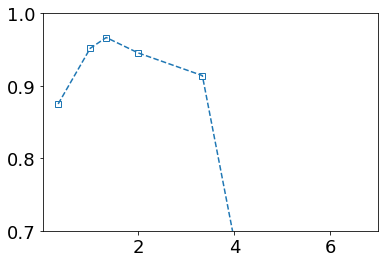

In [10]:
sls=[10,30,40,60,100,200]
fps=[150,75,50,30,25,15]

r2_vals=[]
temp=[]
for k in range(len(sls)):
    file_path=f"./ds5_cnn-pc40_sl{sls[k]}.hdf5"
    predict, y_test=train_model(40, sls[k],30,file_path)
    r2_vals.append(r2_score(y_test,predict))
    temp.append(sls[k]/30)
plt.plot(temp,r2_vals, linestyle='dashed', marker='s', markerfacecolor='none')
plt.ylim(.7,1)